**Goal**

Understand why a bank has a high churn rate, generate insights to reverse this scenario and develop a model capable of predicting churn.

#**1. Setup**

In [ ]:
!pip install lazypredict
!pip install pyngrok==4.1.1

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb

import pickle

##**1.1. Helper function**

In [3]:
# Show confusion matrix, model stats and ROC curve
def model_results(xtrain, xtest, ytrain, ytest, pred, model):
      cm = confusion_matrix(ytest, pred)
      disp = ConfusionMatrixDisplay(confusion_matrix= cm)
      disp.plot()
      print(f"Accuracy (Train): {accuracy_score(ytrain, model.predict(xtrain))}")
      print(f"Accuracy (Test): {accuracy_score(ytest, pred)}")
      print("====================================")
      print(f"Balanced Accuracy (Train): {balanced_accuracy_score(ytrain, model.predict(xtrain))}")
      print(f"Balanced Accuracy (Test): {balanced_accuracy_score(ytest, pred)}")
      print("====================================")
      print(f"Precision (Train): {precision_score(ytrain, model.predict(xtrain))}")
      print(f"Precision (Test): {precision_score(ytest, pred)}")
      print("====================================")
      print(f"Recall (Train): {recall_score(ytrain, model.predict(xtrain))}")
      print(f"Recall (Test): {recall_score(ytest, pred)}")
      print("====================================")
      print(f"F1-Score (Train): {f1_score(ytrain, model.predict(xtrain))}")
      print(f"F1-Score (Test): {f1_score(ytest, pred)}")
      print("====================================")
      print(f"ROCAUC (Train): {roc_auc_score(ytrain, model.predict_proba(xtrain)[:,1])}")
      print(f"ROCAUC (Test): {roc_auc_score(ytest, model.predict_proba(xtest)[:,1])}")
      RocCurveDisplay.from_estimator(model, xtest, ytest)

#**2. Uploading file .csv**

In [4]:
df = pd.read_csv('BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.00,777,11914.00,1.33,1144,42,1.62,0.06,0.00,1.00
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.00,864,7392.00,1.54,1291,33,3.71,0.10,0.00,1.00
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.00,0,3418.00,2.59,1887,20,2.33,0.00,0.00,1.00
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.00,2517,796.00,1.41,1171,20,2.33,0.76,0.00,1.00
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.00,0,4716.00,2.17,816,28,2.50,0.00,0.00,1.00


#**3. Data Understanding**

In [ ]:
# Checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [ ]:
# Checking distribution of numerical data
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00
mean,739177606.33,46.33,2.35,35.93,3.81,2.34,2.46,8631.95,1162.81,7469.14,0.76,4404.09,64.86,0.71,0.27,0.16,0.84
std,36903783.45,8.02,1.30,7.99,1.55,1.01,1.11,9088.78,814.99,9090.69,0.22,3397.13,23.47,0.24,0.28,0.37,0.37
min,708082083.00,26.00,0.00,13.00,1.00,0.00,0.00,1438.30,0.00,3.00,0.00,510.00,10.00,0.00,0.00,0.00,0.00
25%,713036770.50,41.00,1.00,31.00,3.00,2.00,2.00,2555.00,359.00,1324.50,0.63,2155.50,45.00,0.58,0.02,0.00,1.00
50%,717926358.00,46.00,2.00,36.00,4.00,2.00,2.00,4549.00,1276.00,3474.00,0.74,3899.00,67.00,0.70,0.18,0.00,1.00
75%,773143533.00,52.00,3.00,40.00,5.00,3.00,3.00,11067.50,1784.00,9859.00,0.86,4741.00,81.00,0.82,0.50,0.00,1.00
max,828343083.00,73.00,5.00,56.00,6.00,6.00,6.00,34516.00,2517.00,34516.00,3.40,18484.00,139.00,3.71,1.00,1.00,1.00


### Understanding categorical features

In [5]:
df.groupby('Attrition_Flag').CLIENTNUM.nunique()

Attrition_Flag
Attrited Customer    1627
Existing Customer    8500
Name: CLIENTNUM, dtype: int64

<Axes: xlabel='Card_Category', ylabel='Count'>

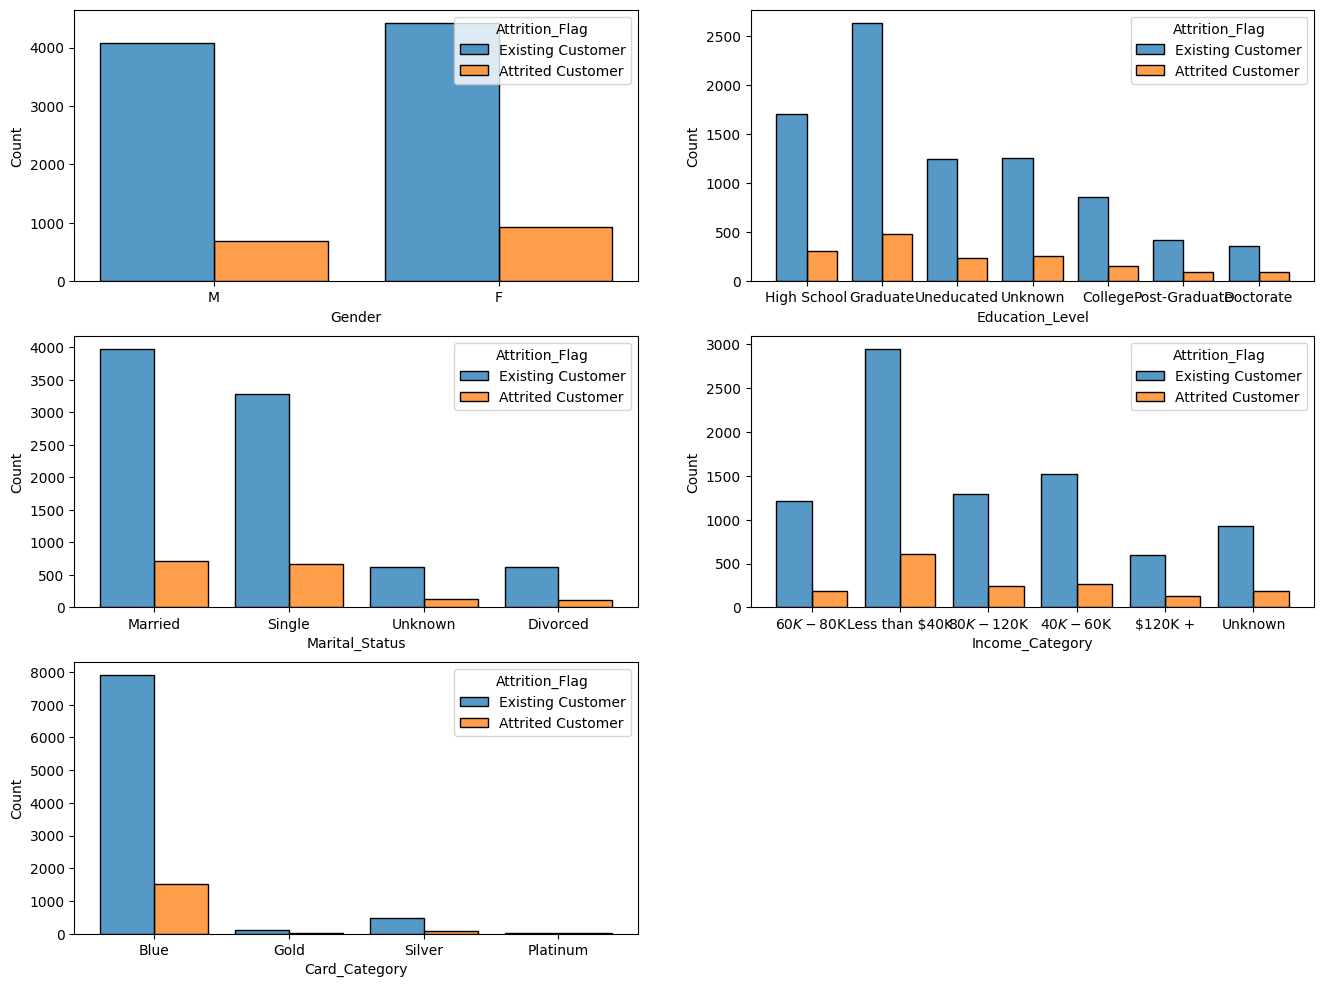

In [6]:
plt.figure(figsize=((16,12)))

plt.subplot(3,2,1)
sns.histplot(data=df, x='Gender', hue='Attrition_Flag', multiple='dodge', shrink=.8)

plt.subplot(3,2,2)
sns.histplot(data=df, x='Education_Level', hue='Attrition_Flag', multiple='dodge', shrink=.8)

plt.subplot(3,2,3)
sns.histplot(data=df, x='Marital_Status', hue='Attrition_Flag', multiple='dodge', shrink=.8)

plt.subplot(3,2,4)
sns.histplot(data=df, x='Income_Category', hue='Attrition_Flag', multiple='dodge', shrink=.8)

plt.subplot(3,2,5)
sns.histplot(data=df, x='Card_Category', hue='Attrition_Flag', multiple='dodge', shrink=.8)

#**4. Data Preparation**

In [7]:
df1 = df.copy()

In [8]:
# Changing values in column "Attrition_Flag" 0 = Existing Customer // 1 = Attrited Customer
df1['Attrition_Flag'] = df1['Attrition_Flag'].replace({'Existing Customer':0, 'Attrited Customer':1})

In [9]:
# Changing values in column "Gender" 0 = M // 1 = F
df1['Gender'] = df1['Gender'].replace({'M':0, 'F':1})

In [10]:
df1 = df1.drop(columns='CLIENTNUM')

In [ ]:
df1.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0,45,0,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.00,777,11914.00,1.33,1144,42,1.62,0.06,0.00,1.00
1,0,49,1,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.00,864,7392.00,1.54,1291,33,3.71,0.10,0.00,1.00
2,0,51,0,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.00,0,3418.00,2.59,1887,20,2.33,0.00,0.00,1.00
3,0,40,1,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.00,2517,796.00,1.41,1171,20,2.33,0.76,0.00,1.00
4,0,40,0,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.00,0,4716.00,2.17,816,28,2.50,0.00,0.00,1.00


#**5. Data Modeling**

In [11]:
df2 = df1.copy()

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   Attrition_Flag                                                                                                                      10127 non-null  int64  
 1   Customer_Age                                                                                                                        10127 non-null  int64  
 2   Gender                                                                                                                              10127 non-null  int64  
 3   Dependent_count                                                                  

In [13]:
cat_vars = ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
num_vars = ['Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
model_vars = cat_vars + num_vars

In [ ]:
df2.corr()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
Attrition_Flag,1.00,0.02,0.04,0.02,0.01,-0.15,0.15,0.20,-0.02,-0.26,-0.00,-0.13,-0.17,-0.37,-0.29,-0.18,1.00,-1.00
Customer_Age,0.02,1.00,0.02,-0.12,0.79,-0.01,0.05,-0.02,0.00,0.01,0.00,-0.06,-0.05,-0.07,-0.01,0.01,0.02,-0.02
Gender,0.04,0.02,1.00,-0.00,0.01,-0.00,0.01,-0.04,-0.42,-0.03,-0.42,-0.03,-0.02,0.07,0.01,0.26,0.04,-0.04
Dependent_count,0.02,-0.12,-0.00,1.00,-0.10,-0.04,-0.01,-0.04,0.07,-0.00,0.07,-0.04,0.03,0.05,0.01,-0.04,0.02,-0.02
Months_on_book,0.01,0.79,0.01,-0.10,1.00,-0.01,0.07,-0.01,0.01,0.01,0.01,-0.05,-0.04,-0.05,-0.01,-0.01,0.01,-0.01
Total_Relationship_Count,-0.15,-0.01,-0.00,-0.04,-0.01,1.00,-0.00,0.06,-0.07,0.01,-0.07,0.05,-0.35,-0.24,0.04,0.07,-0.15,0.15
Months_Inactive_12_mon,0.15,0.05,0.01,-0.01,0.07,-0.00,1.00,0.03,-0.02,-0.04,-0.02,-0.03,-0.04,-0.04,-0.04,-0.01,0.15,-0.15
Contacts_Count_12_mon,0.20,-0.02,-0.04,-0.04,-0.01,0.06,0.03,1.00,0.02,-0.05,0.03,-0.02,-0.11,-0.15,-0.09,-0.06,0.21,-0.21
Credit_Limit,-0.02,0.00,-0.42,0.07,0.01,-0.07,-0.02,0.02,1.00,0.04,1.00,0.01,0.17,0.08,-0.00,-0.48,-0.02,0.02
Total_Revolving_Bal,-0.26,0.01,-0.03,-0.00,0.01,0.01,-0.04,-0.05,0.04,1.00,-0.05,0.06,0.06,0.06,0.09,0.62,-0.26,0.26


In [14]:
x = df2.filter(model_vars)
y = df2[['Attrition_Flag']]

In [15]:
y = pd.DataFrame(y)
y.head()

,Attrition_Flag
0,0
1,0
2,0
3,0
4,0


In [16]:
x = pd.get_dummies(x)
x.head()

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,0,3,39,5,1,3,12691.00,777,11914.00,...,False,False,True,False,False,False,True,False,False,False
1,49,1,5,44,6,1,2,8256.00,864,7392.00,...,False,False,False,False,True,False,True,False,False,False
2,51,0,3,36,4,1,0,3418.00,0,3418.00,...,False,False,False,True,False,False,True,False,False,False
3,40,1,4,34,3,4,1,3313.00,2517,796.00,...,False,False,False,False,True,False,True,False,False,False
4,40,0,3,21,5,1,0,4716.00,0,4716.00,...,False,False,True,False,False,False,True,False,False,False


In [17]:
scaler = MinMaxScaler()

x = pd.DataFrame(scaler.fit_transform(x), index=x.index, columns=x.columns)
x.head()

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.40,0.00,0.60,0.60,0.80,0.17,0.50,0.34,0.31,0.35,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.49,1.00,1.00,0.72,1.00,0.17,0.33,0.21,0.34,0.21,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
2,0.53,0.00,0.60,0.53,0.60,0.17,0.00,0.06,0.00,0.10,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.30,1.00,0.80,0.49,0.40,0.67,0.17,0.06,1.00,0.02,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
4,0.30,0.00,0.60,0.19,0.80,0.17,0.00,0.10,0.00,0.14,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [19]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

100%|██████████| 29/29 [00:21<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 1208, number of negative: 6387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 7595, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159052 -> initscore=-1.665299
[LightGBM] [Info] Start training from score -1.665299


In [20]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.94,0.94,0.97,0.20
XGBClassifier,0.97,0.94,0.94,0.97,7.46
AdaBoostClassifier,0.95,0.90,0.90,0.95,0.63
BaggingClassifier,0.95,0.90,0.90,0.95,0.57
RandomForestClassifier,0.95,0.88,0.88,0.95,1.31
DecisionTreeClassifier,0.93,0.87,0.87,0.93,0.15
ExtraTreeClassifier,0.87,0.78,0.78,0.87,0.04
LinearDiscriminantAnalysis,0.90,0.78,0.78,0.90,0.15
ExtraTreesClassifier,0.92,0.77,0.77,0.91,0.85


In [21]:
# Building the LightGBM model
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1208, number of negative: 6387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 7595, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159052 -> initscore=-1.665299
[LightGBM] [Info] Start training from score -1.665299


LGBMClassifier()

In [22]:
pred = lgbm.predict(x_test)

Accuracy (Train): 0.9998683344305465
Accuracy (Test): 0.9707740916271722
Balanced Accuracy (Train): 0.9999217159855958
Balanced Accuracy (Test): 0.9423084959908374
Precision (Train): 0.9991728701406121
Precision (Test): 0.921760391198044
Recall (Train): 1.0
Recall (Test): 0.8997613365155132
F1-Score (Train): 0.9995862639635912
F1-Score (Test): 0.9106280193236715
ROCAUC (Train): 1.0
ROCAUC (Test): 0.9940430136432381


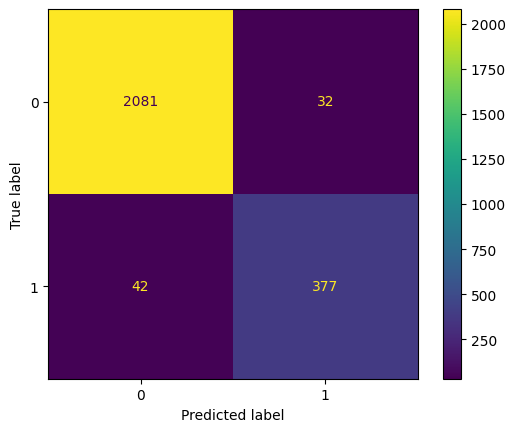

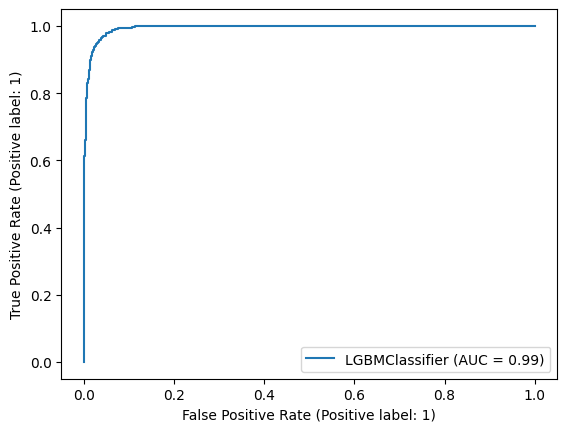

In [23]:
model_results(x_train, x_test, y_train, y_test, pred, lgbm)